# Tensor Networks: An introduction

In this python notebook, you will find some code to gain understanding about tensor networks's basics and to then go on to implement them to implement and use the DMRG algorithm.

But you will find very good resources, images of which have been used in this notebook, at:

https://www.tensors.net/

https://tensornetwork.org/


## 0. The speed of things

Programming has become a very powerful tool to study physics, specially via simulations, and providing fast algorithms is thus a very important requirement to study complex systems. In quantum physics, the curse of dimensionality is an imposing expoential barrier, so the need to find algorithms to give us the speed necessary to tackle this challenge is paramount. 

A useful tool to calculate the time a piece of code needs to run is `%timeit`, an [IPython magic function](https://ipython.readthedocs.io/en/stable/interactive/tutorial.html#magic-functions). The main use we need to understand is:

`%timeit -n <N> <CODE>`

will tell us the averaged time, over N loops, the code on the right took. If we don't set N, it will be adjusted automatically. With `-r <R>` we can set the number of repetitions over which to calculate variance, by default 7. Finally, with `-o` the result will be saved as a variable `t = %timeit -o ...`, with most useful to us properties: `t.average` and `t.stdev`

To motivate how thinking in terms of tensor networks can speed up things, and the need to come up with fast algorithms, let's look at how different methods can result in drastically different speeds for such a simple problem as calculating Fibonnaci numbers!

Let's take a brief recap, the Fibbonaci numbers are defined by the recursion:
$$F(n) = F(n-1) + F(n-2)$$ 
with $F(1)=F(2) = 1$.

Now, if we are given the task to calculate Fibbonaci numbers, the most direct approach would be then to use this recursion directly:

In [1]:
def fib_recursive(n):
    if n <= 2:
        return 1
    else: return fib_recursive(n-1) + fib_recursive(n-2) 


for n in range(12, 20+1):
    print("\nn: {:2d}".format(n))
    %timeit -n 1000 fib_recursive(n)


n: 12


29.5 µs ± 3.16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

n: 13
52.9 µs ± 14.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

n: 14
92 µs ± 36.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

n: 15
125 µs ± 19 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

n: 16
209 µs ± 29.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

n: 17
320 µs ± 32.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

n: 18
566 µs ± 83.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

n: 19
911 µs ± 71.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

n: 20
1.5 ms ± 136 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Now, this is exponentially slow! We can notice that by increasing $n$, we are calling the same small $n$ terms many more times. Note that the only thing that adds an actual number is F(1) or F(0), which are 1. Therefore, we need to add them Fib(n) times, so we call them Fib(n) times!!! Exponential.

There are much faster ways, example:

In [2]:
def fib_sequential(n):
    if n<= 2:
        return 1
    fold = 1  # F1
    fnew = 1  # F2

    for _ in range(2, n):
        temp = fold
        fold = fnew     # F2            -> F3
        fnew += temp    # F2 + F1 = F3  -> F2+F3 = F4

    return fnew

for n in range(12, 20+1):
    print("\nn: {:2d}".format(n))
    %timeit -n 1000 fib_sequential(n)

import numpy as np
for n in 2**np.arange(5, 15):
    print("\nn: {:2d}".format(n))
    %timeit -n 10 fib_sequential(n)


n: 12
855 ns ± 401 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)

n: 13
832 ns ± 233 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)

n: 14
1 µs ± 241 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)

n: 15
1.21 µs ± 351 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)

n: 16
1.13 µs ± 285 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)

n: 17
1.2 µs ± 170 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)

n: 18
1.59 µs ± 315 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)

n: 19
1.64 µs ± 734 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)

n: 20
2.1 µs ± 499 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)

n: 32
1.74 µs ± 110 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)

n: 64
3.41 µs ± 103 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)

n: 128
6.28 µs ± 94.3 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)

n: 256
13.7 µs ± 438 ns per loop (mean ± std. dev. of 7 runs, 

## 1. Tensor Networks

To not get lost in the introduction of tensor networks, the fundamental idea to keep in mind is that by themselves they are **not** a new piece of math, but rather, they serve as an elegant and powerful framework in which to reexpress and tackle problems. So first of all, we do a small recap of tensors:

### 1.1 Fundamentals


A tensor $T$ is many times understood, to the dismay of mathematicians, as generalised vectors and matrices with more dimensions. As a more formal but also useful definition for our purposes, we will construct tensors using the idea of tensor products which is well explained in appendix A of reference [1].

To cut to the chase, the important idea is that a generic tensor of type $(p,q)$ will correspond to:
$$\sum T^{i_1, i_2, \dots, i_p}_{j_1,\dots,j_q} \ket{\Psi_{i_1}}\otimes\dots\otimes\ket{\psi_{i_p}} \otimes \bra{\phi_{j_1}}\otimes\dots\otimes\bra{\varphi_{j_q}}$$

And therefore, all the information of our tensor, given all of these basis, is stored in the coefficients $T^{i_1, i_2, \dots, i_p}_{j_1,\dots,j_q}$. Each index runs through the dimension of the corresponding orthogonal bases for each Hillbert space, which we usually consider the same for all indices (for instance, when considering spin chains).

This is why, from now on, we talk about tensors considering only these coefficients, and why they may seem like a generalization of matrices. In particular, for quantum mechanical purposes usually we will most commonly use them as follows:
- $(N,0)$ tensors, e.g. representing a composite system N particles
$$\ket{\Psi} = \sum T^{i_1, i_2, \dots, i_N} \ket{\psi^{(1)}_{i_1}}\otimes\dots\otimes\ket{\psi^{(N)}_{i_N}}$$
- $(N,N)$ tensors, e.g. representing an operator acting on a composite system or density matrices
$$\hat{O} = \sum T^{i_1, i_2, \dots, i_N}_{j_1, j_2, \dots, j_N} \ket{\psi^{(1)}_{i_1}}\otimes\dots\otimes\ket{\psi^{(N)}_{i_N}} \bra{\psi^{(1)}_{j_1}}\otimes\dots\otimes\bra{\psi^{(N)}_{j_N}}$$


Now we talk about how we represent these in tensor network, but we note that from now on we only describe a tensor via its coefficients, with the basis asumed. 

The distinction between upper and lower indices is useful to make sense of the meaning of everything, but actually for our uses we numerically can treat everything the same, i.e. if we only care about our coefficients, as numbers:
$$A^{a, b}_{c, d, e} \equiv A_{a,b,c,d,e}$$

To implement a tensor then, we just need to use numpy arrays of different dimensions. Instead of treating ranks as $(p,q)$, we can just talk about the total rank $p+q$, which corresponds to the array dimension

EXAMPLE: Implementing simple tensors in python

We will use `numpy` arrays.

In [3]:
import numpy as np

In [4]:
### IMPLEMENTING A (1,0) TENSOR REPRESENTING A STATE  |PSI> = (|0> + |1>) / √2
# So a 1 dim array

# this tensor is just a vector
psi = np.array([1.+0j,1.+0j])/np.sqrt(2)
psi = np.ones((2,), dtype=np.complex_)/np.sqrt(2) # useful, creates tensor with lengths (A, B, C, D...)
print(psi)

[0.70710678+0.j 0.70710678+0.j]


In [5]:
### IMPLEMENTING A (1,1) TENSOR REPRESENTING AN X GATE:  X = |0><1| + |1><0|

# NUMERICALLY, WE WILL TREAT INDICES THE SAME, 2 DIM ARRAY (MATRIX)

# this tensor is just a matrix
X = np.array([[0j, 1.], 
              [1., 0j]])
print(X)

print("Shape: ", X.shape)
print("Dimensions (RANK): ", X.ndim)

[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]
Shape:  (2, 2)
Dimensions (RANK):  2


### 1.2 Diagramatic notation

The main thing about tensor networks is the diagramatic language they use. It is the basis of further reasoning and discussion, which provides an easier, intuitive and powerful framework in which to analyze alogrithms and theoritical discussions. So it is introduced next:

#### 1.2.1 Basic tensor


We represent tensors as follows. The images come from Penrose's original paper presenting this notation [2], where upper indices correspond to these "legs" drawn on top, and lower indices on the legs drawn below.

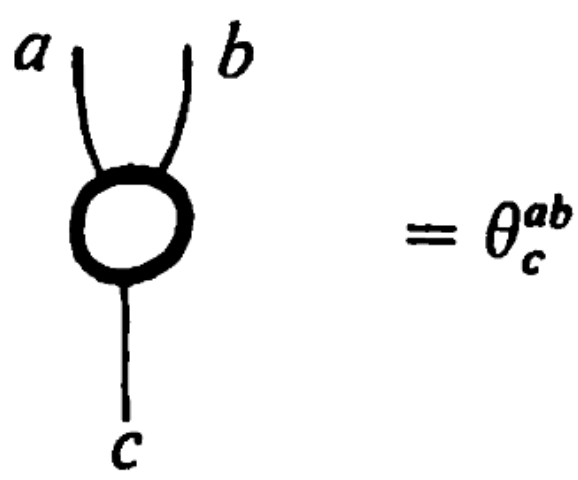

Free legs are treated with dirac deltas, consistent with how one could add them at the end of a tensor diagram drawing, but it should change nothing
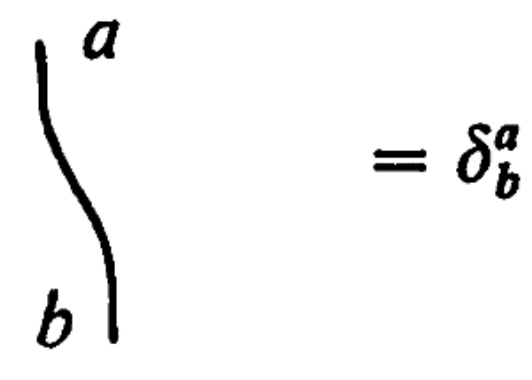


This notation, can vary. For instance, many times this notation is rotated so lower indices point to the left and upper indices to the right, but if you think about it, that's just Quantum Circuit notation! In fact, this probably more familiar to most of you notation comes from tensor networs.

In the end though, this is just notation, and another common and practical way to represent it is for instance with outgoing arrows indicating upper indices and ingoing arrows indicating lower indices:


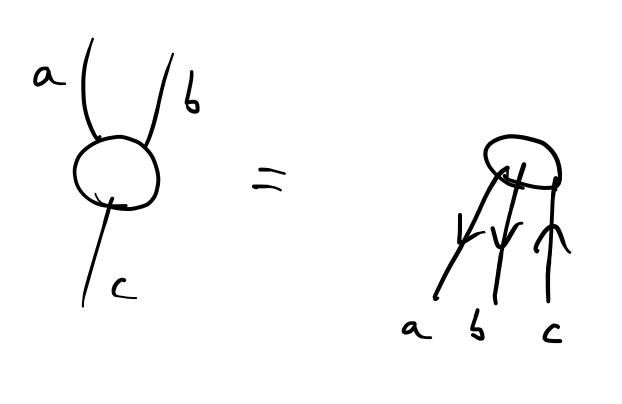

The main takeaway is that the notation can vary, and if there's room for ambiguity, one should clarify what is what.

In [6]:
### REPRESENT THIS TENSOR
### With sizes 2, 4, 4. Such that it is 1 if a=b=c, otherwise 0

# hint: you can use   " np.zeros(shape) "  to create a zeros initialized tensor

O = np.zeros((2,4,4))

O[0,0,0] = 1
O[1,1,1] = 1

O

array([[[1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]])

#### 1.2.2. Tensor product


And we can perform some operations with tensors. The first one is to perform the tensor product, which we represent:
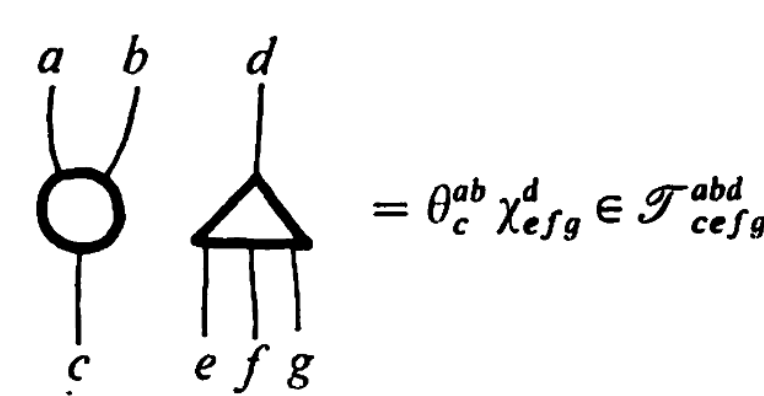


A very very useful tool is numpy's einsum, which can be used to do this kind of notation. Given our $\theta^{a,b}_c$, stored as `A[a,b,c]`, and our $\chi^{d}_{e,f,g}$, stored as `B[d,e,f,g]`, we could manually build index by index:

C[a,b,d,c,e,f,g] = A[a,b,c] · B[d,e,f,g]

Or we can instead of looping just use:

`C = np.einsum('abc, defg -> abdcefg', A, B)`

If we want to conserve our upper leg first index ordering. 

We can also not specify, but then we would get equivalently
`C = np.einsum('abc, defg', A, B) == np.einsum('abc, defg -> abcdefg', A, B)`

Implement the following tensor contraction, corresponding to a product state of two qubits:

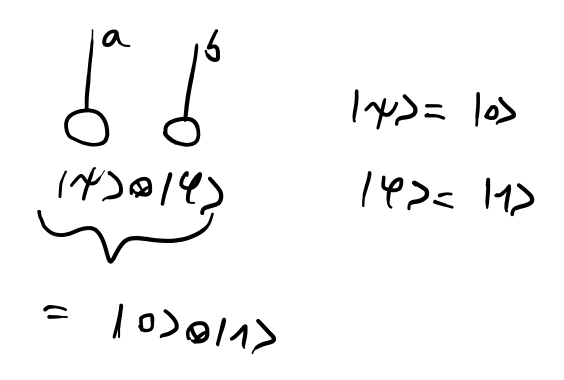

In [16]:
### Implement the previous tensor product. You can build it manually or using einsum

# Solution:
psi = np.array([1,0])
phi = np.array([0,1])

Psi = np.einsum('a,b', psi, phi)
print(Psi)

[[0 1]
 [0 0]]


### 1.2.3. Index grouping and permuting

Another operation you can do is index grouping. This is very useful, and this is what we usually do when treating multipartite systems in QM anyways. For instance, with two qubits we rewrite the states as:

$$\frac{1}{\sqrt{2}}(\ket{0}\otimes\ket{0} + \ket{1}\otimes\ket{1}) \to \frac{1}{\sqrt{2}}(\ket{00} + \ket{11})$$

Implicitly, we are working in a single vector space of basis $\ket{00}, \ket{01}, \ket{10}, \ket{11}$. We can do this with numpy.reshape

In [17]:
#### Reshape the tensor
Psi = np.array([[1.,0j],
                [0,1.]])/np.sqrt(2)
#### as rank 1 tensor

Psi.reshape((2*2))

array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j])

Diagramatically this is drawn as follows, taken from the nicely explained G. Evenbly https://www.tensors.net/tutorial-1
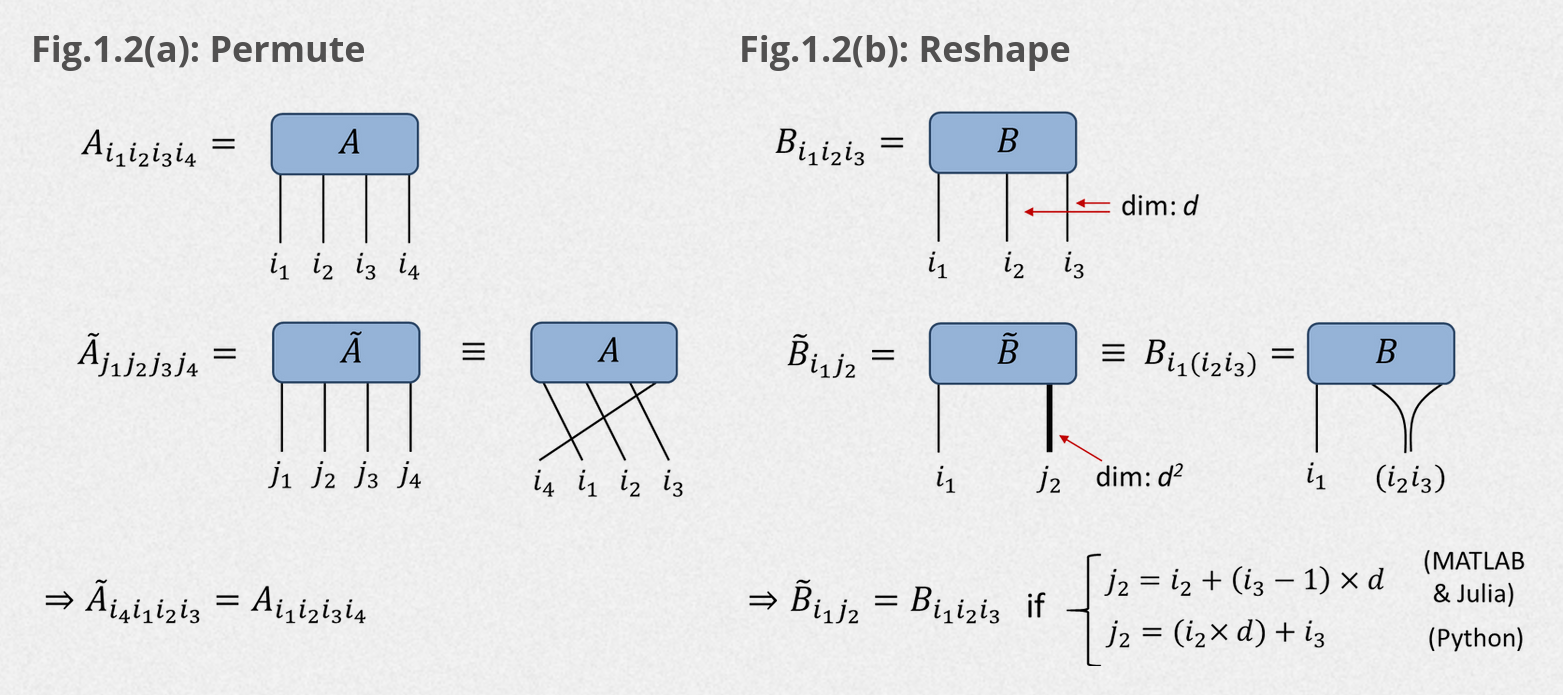

Where we also can see how permutation can be done. Permutation is something we can apply with einsum! It treats the indices in aplhabetical order if we don't specify output ordering manually:

In [56]:
T = np.array([[0,1],[0,1]])

print("Before permutation:")
print(T)

Tpermute = np.einsum('ba', T) 

print("\nAfter permutation (transposition)")
print(Tpermute)

Tpermute2 = np.einsum('ba -> ba', T) 

print("No permutation (manual)")
print(Tpermute2)

Tpermute3 = np.einsum('ij -> ji', T)

print("After permutation (manual)")
print(Tpermute3)


# we can also use np.tranpose(A, new_reordering)
# Where the original legs (0,1,2,3,...)
# they will go into new_reordering. i.e.  np.tranpose(A, (3,1,2,0))    permutes the first and last leg

Before permutation:
[[0 1]
 [0 1]]

After permutation (transposition)
[[0 0]
 [1 1]]
No permutation (manual)
[[0 1]
 [0 1]]
After permutation (manual)
[[0 0]
 [1 1]]


#### 1.2.4. Tensor contraction

Tensor contraction will be one of the most important things we can do with tensors. We use Einstein convention, meaning that the repeated indeces are summed over:
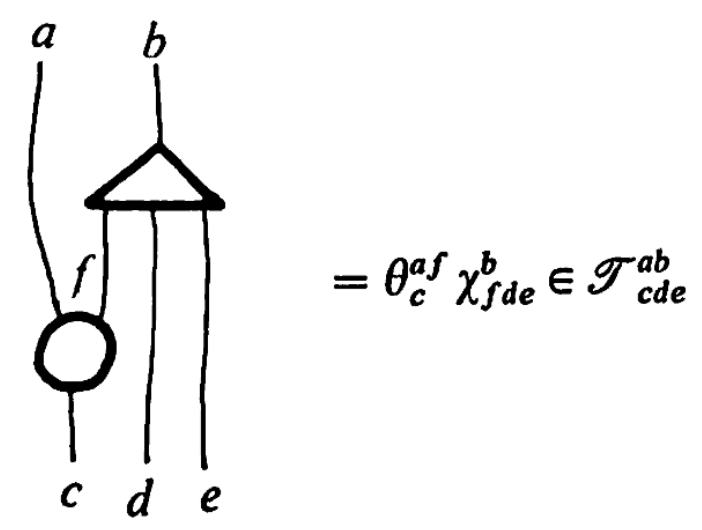

As a reminder to ease things back into familiar territory, matrix multiplication is just a tensor contraction!

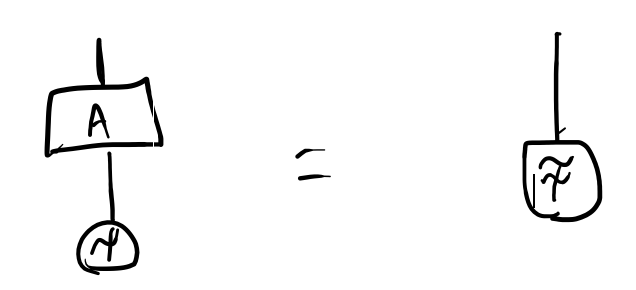

In [41]:
### Implementing tensor contraction:
### Apply an X gate, in tensor form, to a qubit in the 0 state, also in tensor form

ket0 = np.array([1,0j])
X = np.array([[0.,1j], [1,0.]])

print("State before contraction: ", ket0)


Psi = np.einsum('ij,j', X, ket0)   # equivalently 'ij,j -> i'      #    X^i_j  psi^j  
print("State after contraction:  ", Psi)

X@ket0  # matrix multiplication, equivalent

State before contraction:  [1.+0.j 0.+0.j]
State after contraction:   [0.+0.j 1.+0.j]


array([0.+0.j, 1.+0.j])

Now, tensor contraction by itself is a can of worms. As a tensor contraction is a sum of terms, it has cost proportional to the dimensions of the contracted and free indices. When contracting two or more tensors, this means that the order of contractions can speed or slow things down! Usually the strategy is to contract two tensors at a time, but then depending on the order of these contractions the computation speed can vary!

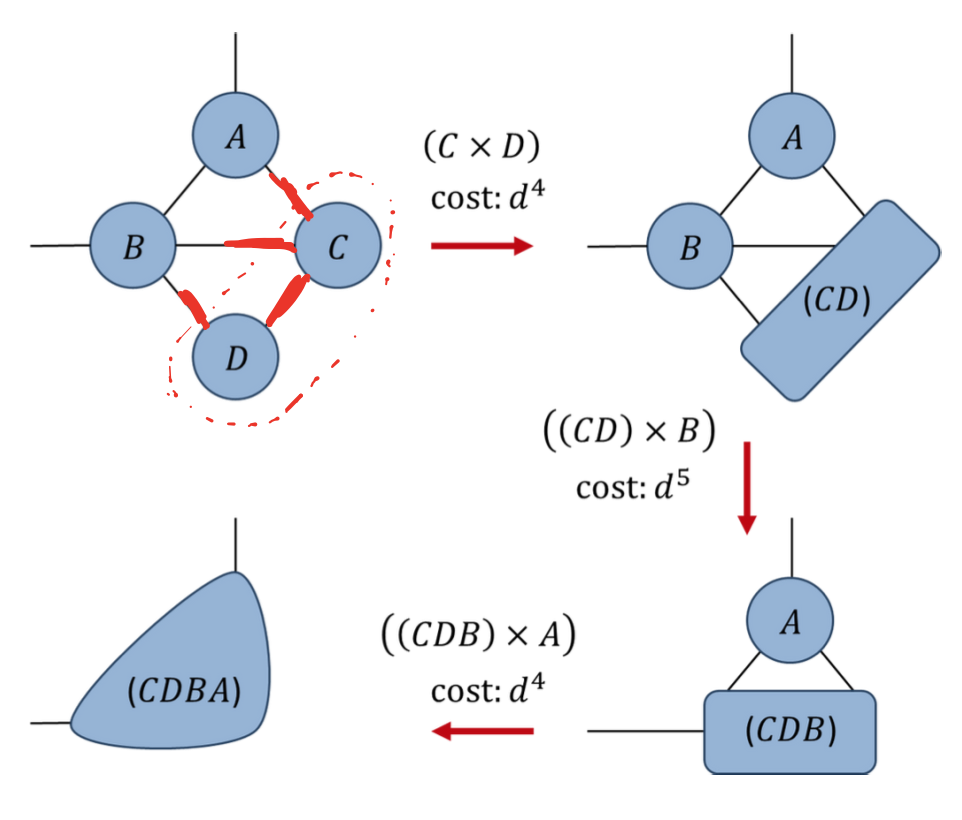

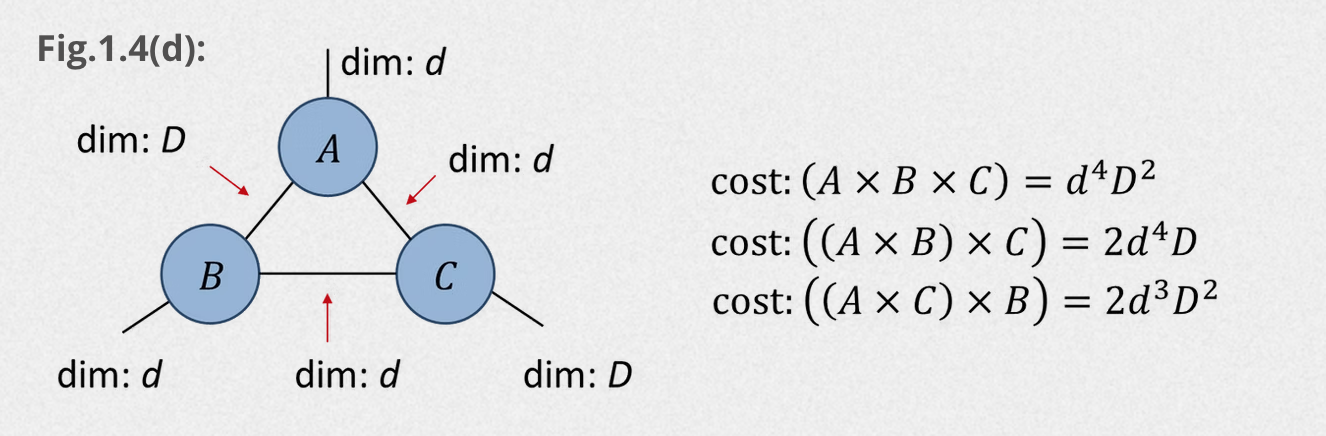


Intuitively, the reason ordering and pairwise contraction affect computation speed, is just how one could group terms in a multiplication:

$$A_{ij}B_{jk}C_{kl} = A_{ij}(B_{jk}C_{kl})$$
$$A_{i1}B_{11}C_{1l} + A_{i1}B_{12}C_{2l} + A_{i2}B_{21}C_{1l} + A_{i2}B_{22}C_{2l} = A_{i1}(B_{11}C_{1l} + B_{12}C_{2l}) + A_{i2}(B_{21}C_{1l} + B_{22}C_{2l})

In the previous example, we could perform 8 multiplications and 3 additions, or calculate the same result using just 6 multiplications and 3 additions, which is faster.

These kind of considerations are important, as one of the main successes of tensor networks are that they can provide faster algorithms. Therefore, it is important to have optimization in mind always. Regardless, this is a bit of a trick, as the generic problem of finding the optimal contraction order of a generic tensor network is **hard**. But for simpler tensor network achitectures it can be known more easily.

In [79]:
# Implement and compute tensor contraction for the previous drawing.
# Hint, after implementing two methods, you can check you get the same results using: np.allclose(ABC_method1, ABC_method2)
d = 40
D = 20
A = np.random.random((D,d,d))    # We chose here to refer to indices starting from first one left from the bottom and clockwise.
B = np.random.random((d,D,d))    # Mantain this convention (or the one you prefer) to compare you get the same results with the different contractions
C = np.random.random((d,d,D))












### SOLUTION
"""
### See Solution drawings in the end if this is not clear, but you should attempt to solve it on your own
def ABC1(A,B,C):
    return np.einsum('abc,daf,fci -> dbi', A,B,C)

def ABC2(A,B,C):
    AB = np.einsum('abc,daf -> dbcf', A,B)
    return np.einsum('dbcf,fci -> dbi', AB, C)

def ABC3(A,B,C):
    AC = np.einsum('abc,gci -> gabi', A,C)
    return np.einsum('daf, fabi -> dbi', B, AC)

%timeit res1 = ABC1(A,B,C)
%timeit res2 = ABC2(A,B,C)
%timeit res3 = ABC3(A,B,C)
print("ABC1 == ABC2? ", np.allclose( ABC1(A,B,C) , ABC2(A,B,C) ))
print("ABC2 == ABC3? ", np.allclose( ABC3(A,B,C) , ABC2(A,B,C) ))
"""

1.75 s ± 118 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
212 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
49.8 ms ± 2.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
ABC1 == ABC2?  True
ABC2 == ABC3?  True


In truth, numpy's einsum is not particularly efficient, there are other methods such as one called ncon (from contraction), which are also better suited when we have many more indices.

As a bonus, calculate now Fibbonaci numbers with tensor networks and find an efficient way to contract the network from the following realisation:
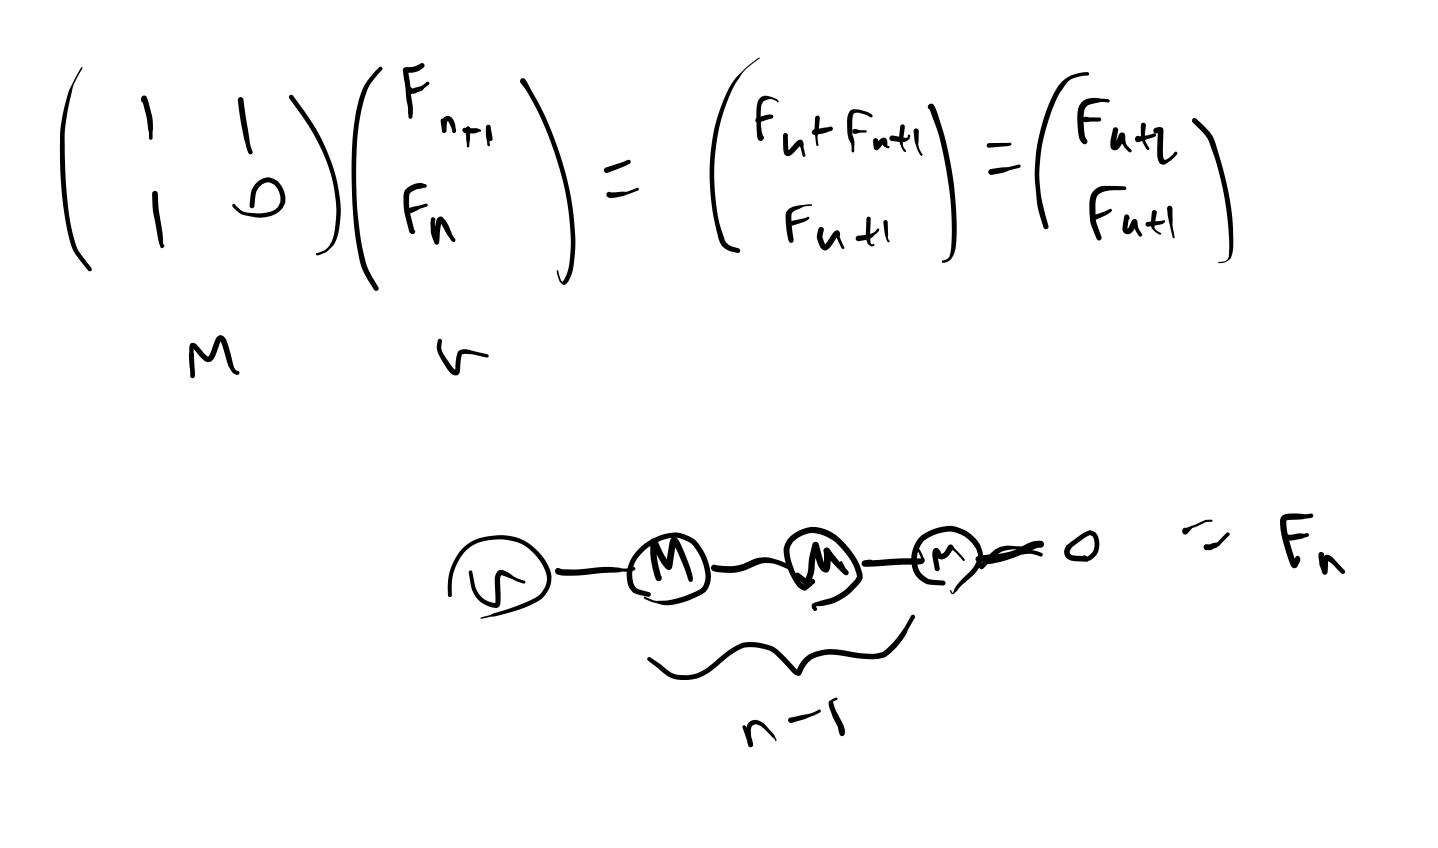

In [105]:
### FIND EFFICIENT FIBONACCI METHOD USING TENSOR NETWORKS

M = np.array([[1,1],[1,0]], dtype=np.longlong)














"""######## SOLUTION

# Observe first that we can indeed get back a "linear complexity" result just contracting straight up
def fib_mps(N):
    v = np.array([1,0])
    for _ in range(N-1):
        v = M@v
    return v[0]


# But actually, the N-1 M matrices can be contracted first.
# We could diagonalize them, to obtain Binet's formula for Fibonacci numbers, but it's not going to be implementable anyways because it will
# be an explicit formula but using irrational numbers. So instead, what we do is reuse already contracted groups of M:
#    -- FAST SQUARING (https://en.wikipedia.org/wiki/Exponentiation_by_squaring)
#       M^(2n) = (M^2)^n
#       M^(2n+1) = (M^n)^2 M
#    Example:   M M M M M M = (MMM)(MMM),    MMM = (MM)M,     MM = M

def fib_mpsFast(N):  # LOGARITHMIC!!! EXPONENTIAL SPEEDUP TO AN ALREADY EXPONENTIAL SPEEDUP
    Mcopy = M.copy()
    v = np.array([1,0])
    for bit_char in bin(N-1)[2:]:  # bit list
        bit = int(bit_char)
        if bit==1:
            Mcopy = Mcopy@M
        else:
            Mcopy = Mcopy@Mcopy
    v = Mcopy@v
    return v[0]

%timeit fib_mps(1000000)
%timeit fib_mpsFast(1000000)

#print(fib_mpsFast(100000))   # it is actually wrong! We need python integers, which can be much bigger than 64 bit



# In truth we are limited by arithmetic operation speed. Our actul performance is more akin to N^2 log N. The N^2 appears due to
# our fibonacci numbers growing exponentially with N, and arithmetic operations depend on the number of bits, so grow with N.
# Actually, there are fast multiplication alogrithms to bring our speed to N^1.58 log N  !!!

# In this spirit, one must say that our implementation is wrong, it shows this asymptotic behaviour in terms of the size of N,
# but it does not actually give the correct fibonacci number, as numpy integers aren't big enough to represent even fibonacci(100)
# Regardless, it is correct, we could interpret that we are computing the Nth fibonacci's residue over the maximum integer we can represent

# For a good discussion see https://www.youtube.com/watch?v=KzT9I1d-LlQ
"""


1.9 s ± 518 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
70 µs ± 15.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## 2. MPS and MPO

One powerful and fundamental tool is the SVD decomposition. What it tells us is that we can decompose matrices into some unitary transformations and a phase transformation:

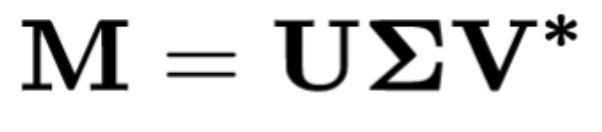


That is, we can transform some

$$A_{ik} = U_{ij} \lambda_j V^*_{jk}$$


With the properties that both matrices are unitary (but the right one appears conjugated ).

We can draw this in tensor network notation

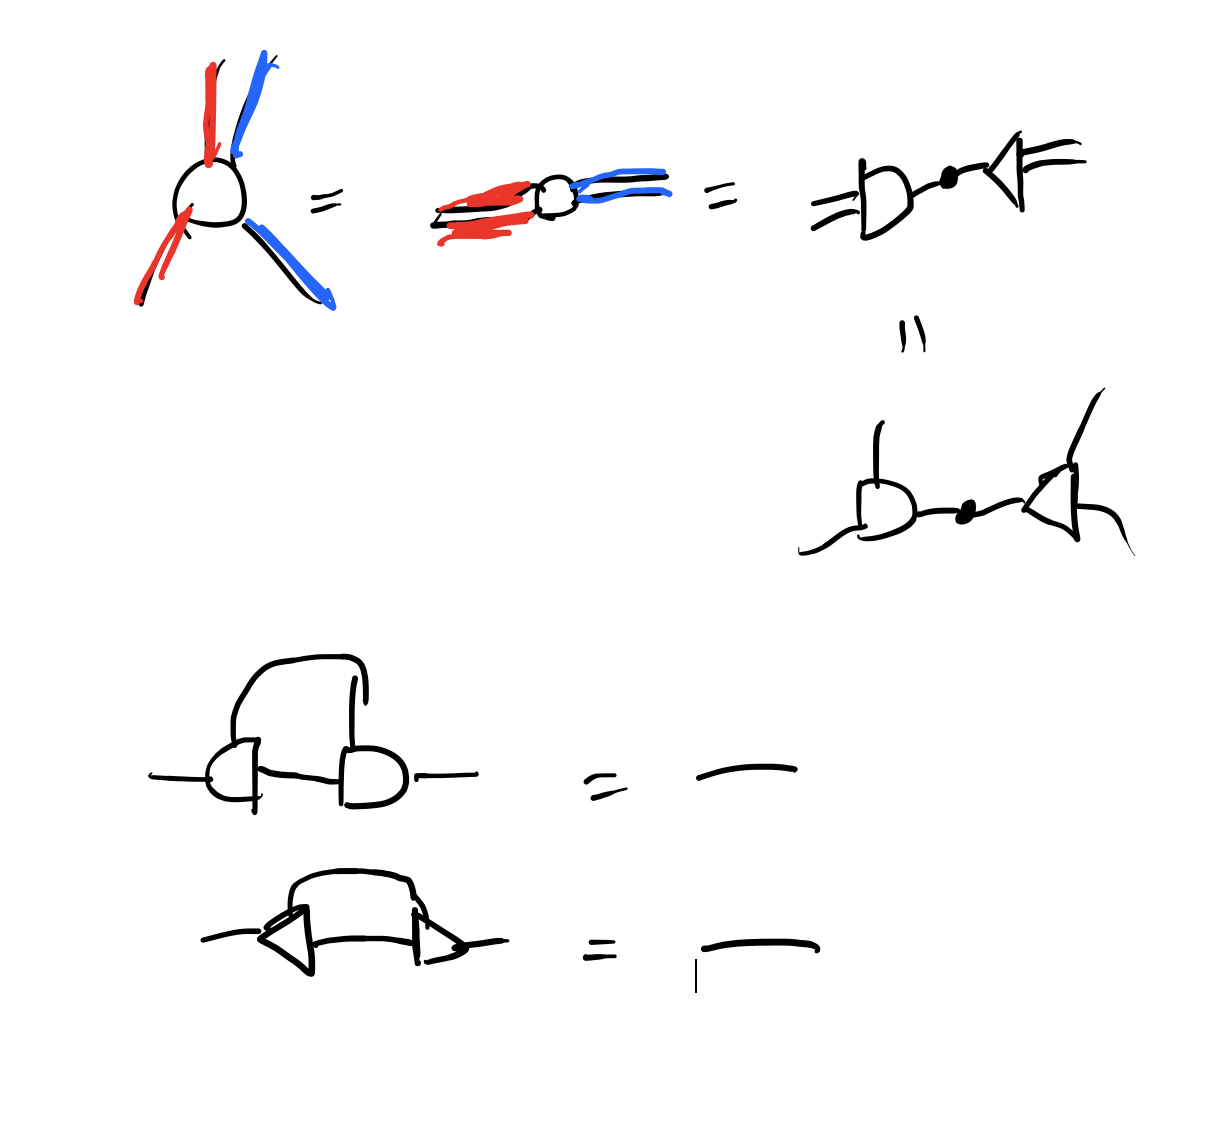



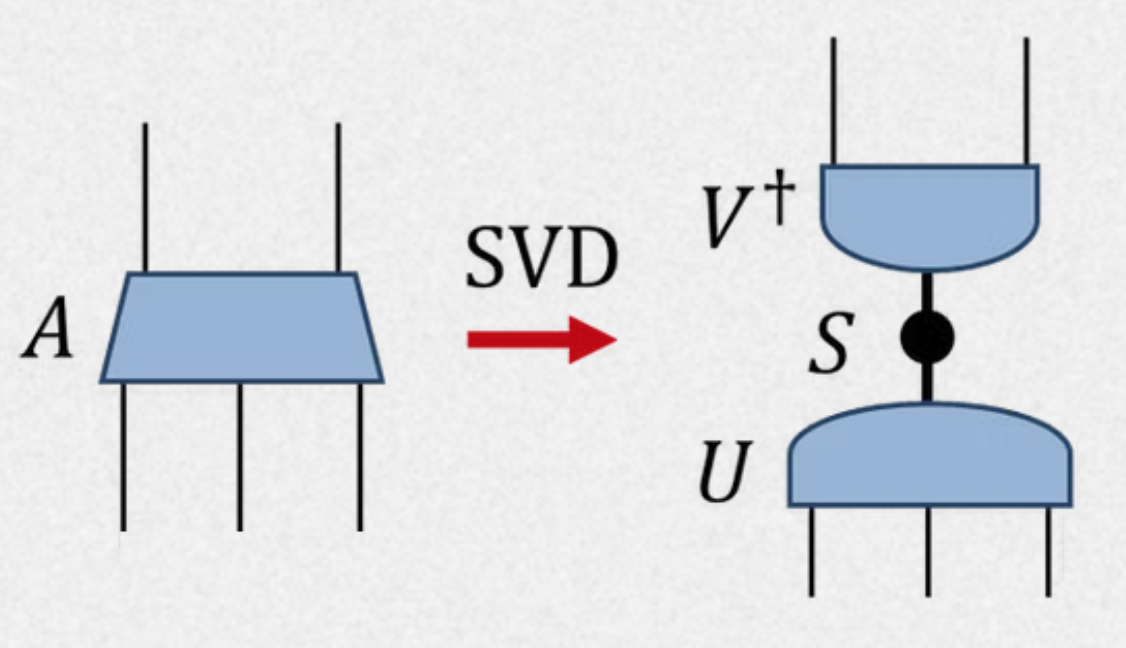    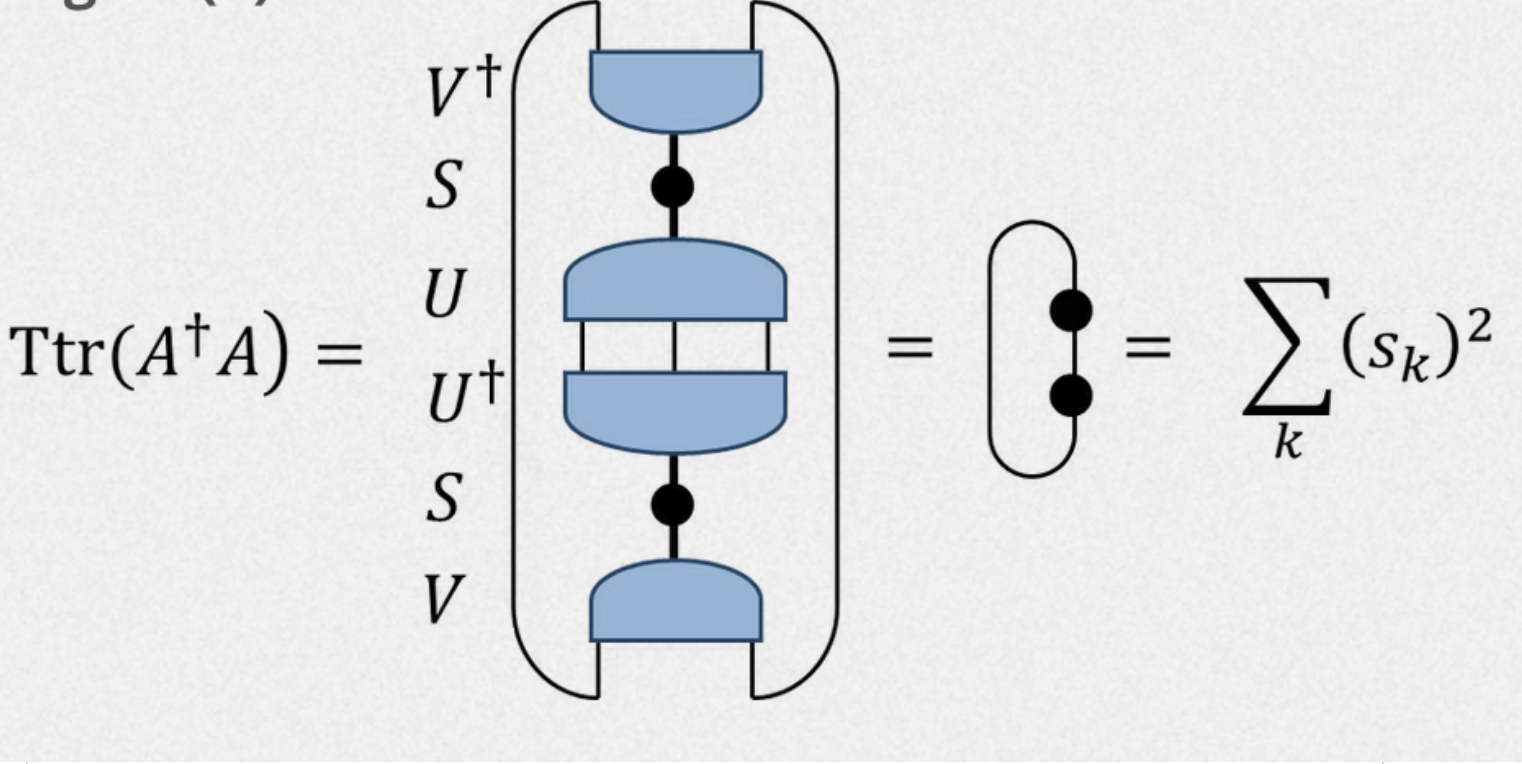

When what we are dealing with are quantum states, the meaning of the SVD decomposition can be taken as that of a Schmidt decomposition. The meaning behind the singular values are that they encode in some sense the entanglement entropy.

The point is that, by itself, this is not too useful, but once we do Schmidt decomposition, we can cut off the small Schmidt values, and thus we will be working in a greatly reduced subspace! 

In the following example, a tensor (matrix with greyscale values) representing a cat, has had its SVD decomposition performed and only the first $n$ singular values have not been cutoff. This visually shows we indeed are not losing information!

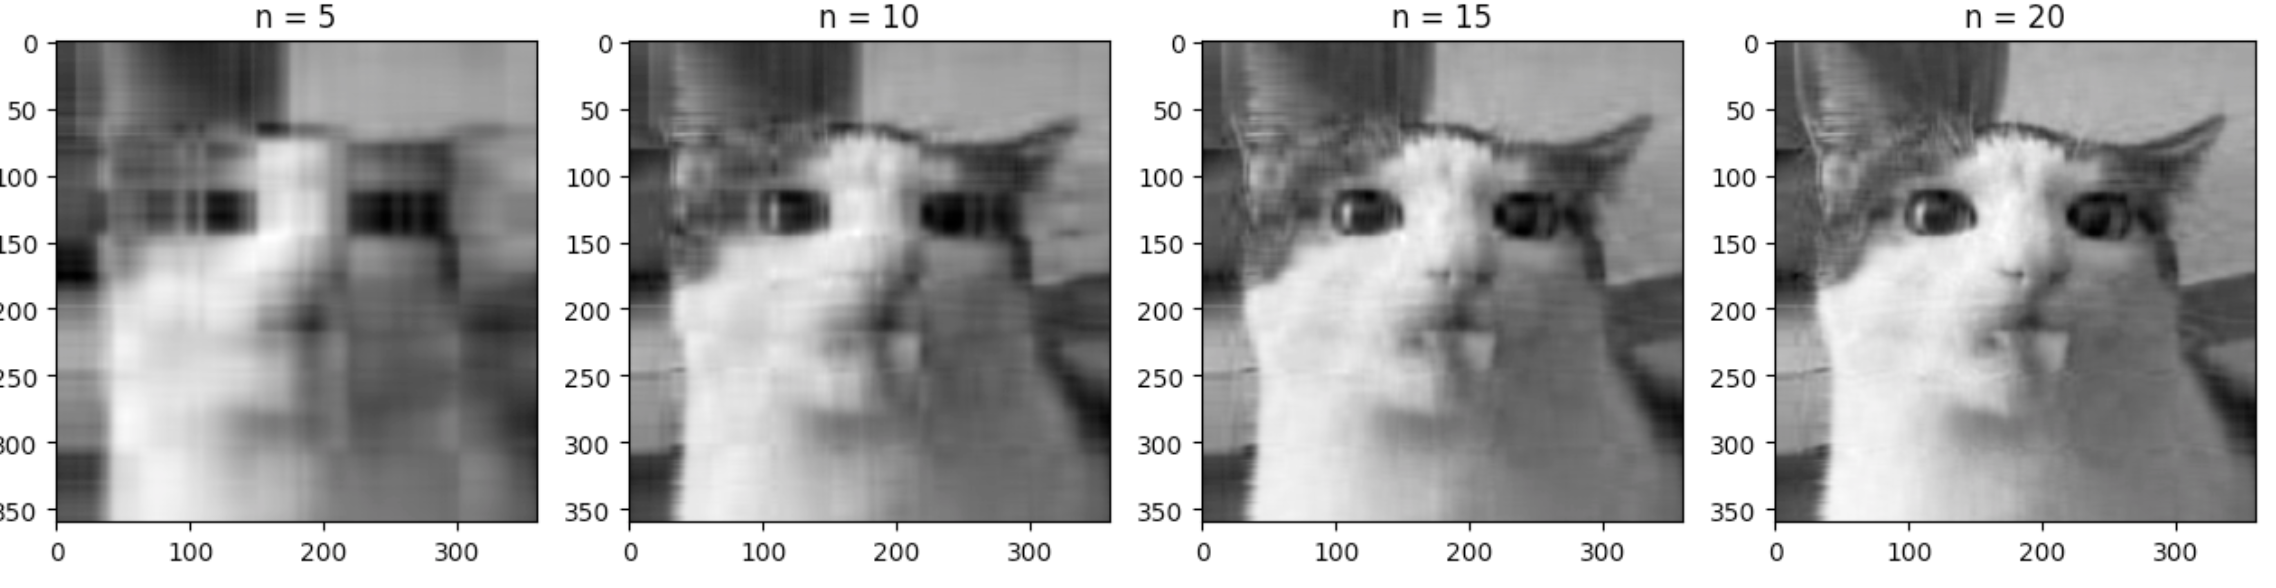

For quantum states, the singular values are closely related to entanglement entropy, as we said, so this also gives us a hint to when will this SVD cutoff be sucessful! If our states are not entangled at all, we already know the representation is efficienet because we have separable states, but for highly entangled states, all our singular values will be important! Therefore, the conclusion is that when we have non highly entangled states we can indeed gain a lot by cutting off the SVDs. 


The point is that we will reduced a generic, exponential sized tensor representing a state, to a tensor network of simpler elements!
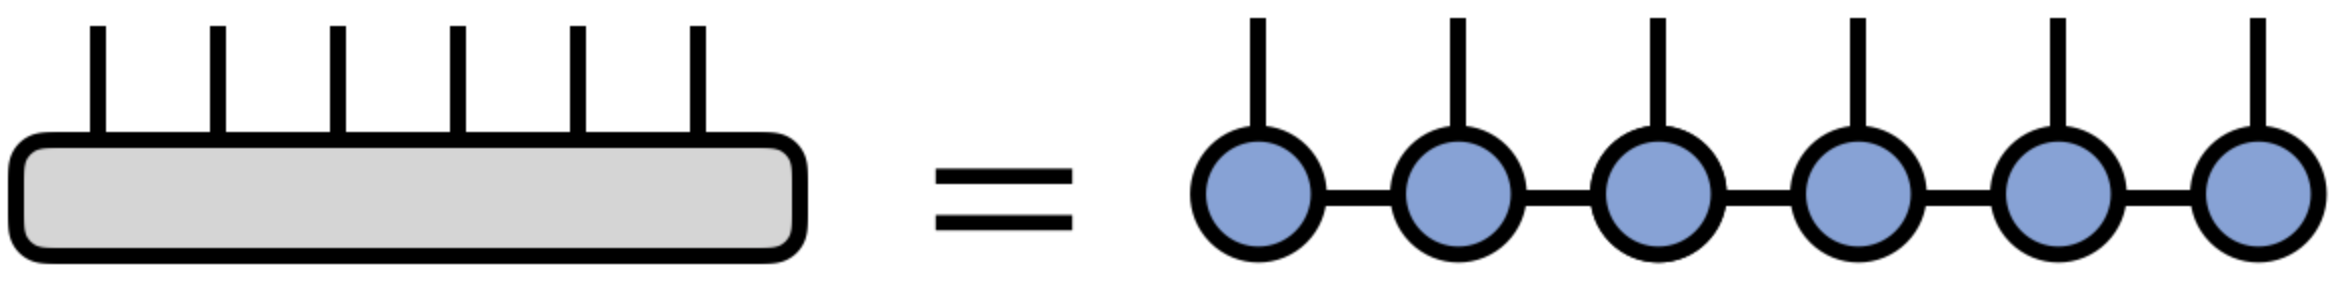



This form can always be achieved using the SVD algorithm iteratively as described before. Furthermore, in the method shown below, the isometricity of the gates resulting from SVD are also a bonus!
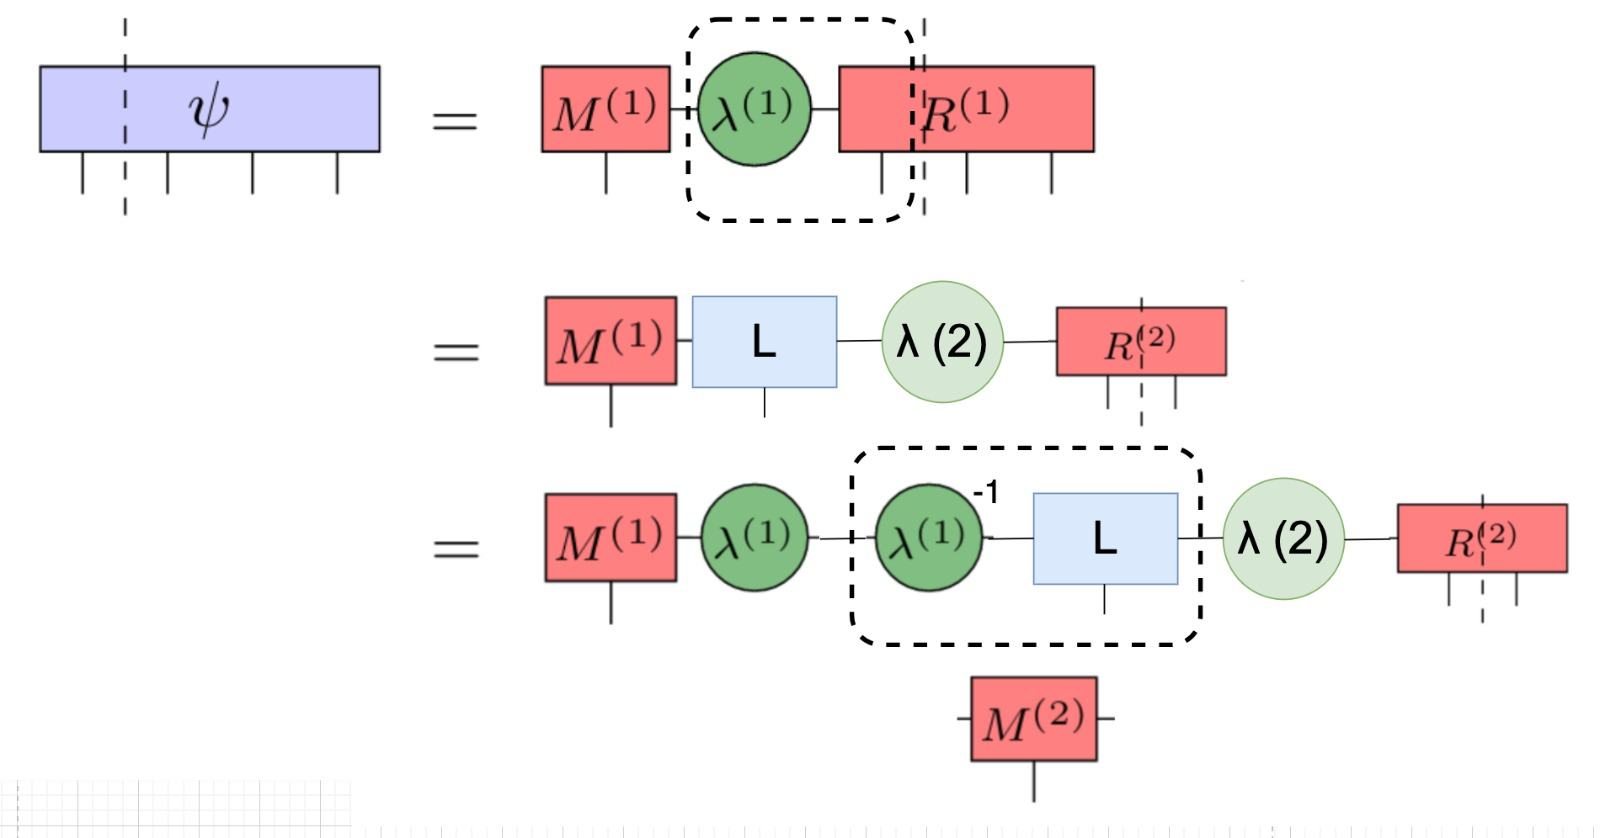

But the point is that the singular values will not all be non 0. In fact, for efficiently representable states, when they are not too entangled, we will be able to very efficiently represent them in this MPS form. And the point is that with many algorithms, instead of starting from a generic state, we already start from MPS ansatz.


Now we will showcase this by finding the MPS of this state:

$$ |W  \rangle =\frac{1}{\sqrt{N}}\sum_{n=1}^{N} |0 \cdots 0 1_n 0\cdots 0\rangle  $$

In [326]:
import numpy as np 
from scipy.linalg import svd
from scipy.linalg import pinv as pseudoinverse



# Compute MPS of a quantum state!
# Hint: 
#  - Start with your full state
#  - Partition your first index and your second index, perform SVD over it.
#  - Obtain an isometry for your first index, the singular value matrix, and the other isometry representing the remainder of the whole state
#  - Repeat recursively for the shortened "full state" on the right, which each time has one less leg. 
#           But now join the previous singular value matrix and the new remainder state, treat that as your new full state.
#           After finishing, multiply again on the left by singulr values and inverse (use pinv, pseudo inverse), as in the drawing above.

# svd has notation:
# U, svals, V = svd(Matrix, full_matrices='False')   # use full_matrices='False' to make tensors smaller

def svd_first_leg(state):
    # Given a tensor, perform svd on its first leg, and return  U, S, V (isometry tensor corresponding to first leg, singular value tensor, and remainder isometry tensor)
    pass
def createMPS(state):
    # Given a state tensor, perform svd on all its parts until it is in MPS form + the inbetween singular values (canonical form)
    # return listTensors, listSingularValueTensors
    pass
def contract_MPS(Tlist, Slist):
    # Given tensor list and singular value list, contract them to get back the tensor the MPS is representing
    pass






#### SOLUTIONS

def svd_first_leg(state):
    shape = state.shape
    size1 = shape[0]
    sizerest = np.prod(shape[1:])

    # combine all legs other than the first into one
    state = state.reshape((size1, sizerest))

    # svd of this new bipartite system (matrix form!)
    U, svals, Vrest = svd(state, full_matrices=False)

    # put original state back into initial shape to leave it as it was before, in case we need it again
    state = state.reshape(shape)

    # put Vrest back into previous shape, unravel joined indices
    Vrest = Vrest.reshape((Vrest.shape[0],)+shape[1:])

    return U, np.diag(svals), Vrest  # svals is actually not in tensor form, but in diagonal form (1d array), that's why we convert it into matrix with np.diag


def createMPS(state):
    # returns list of tensors now constituting our system, and inbetween singular values
    N = len(state.shape)
    shape = state.shape
    Tlist = []
    Slist = []

    rest_state = state.copy()

    # svd of first state
    T, S, Vrest = svd_first_leg(rest_state)
    Tlist.append(T); Slist.append(S)
    for n in range(1,N-1):
        # join S and right isometry as new remainder
        Vrest_shape = Vrest.shape
        rest_state = S@ Vrest.reshape((Vrest_shape[0], np.prod(Vrest_shape[1:])))  # equiv to einsum 'ij,j...' with ... signifying rest of indices
                                                                                   # simplified by joining all ..., matrix form

        rest_state = rest_state.reshape((np.prod(Vrest_shape[0:2]),) + Vrest_shape[2:]) # undo matrix form, but join svd index and first pending state index
        T, Snew, Vrest = svd_first_leg(rest_state)
        T = T.reshape((Vrest_shape[0], Vrest_shape[1], Snew.shape[0]))                  # undo mixing, to separate again svd indeex and first pending state

        # to get back the S before the new left unitary, multiply by S and inverse (so T gets multiplied by inverse)
        T = np.einsum('ij,jkl->ikl',pseudoinverse(S),T)
        S = Snew
        Tlist.append(T); Slist.append(S)

    # last tensor is the Vrest tensor, from the right
    Tlist.append(Vrest)

    return Tlist, Slist
        

def contract_MPS(Tlist, Slist):
    # contract tensors and Singular values to get back original tensor (or approximation of it, if we applied cutoff)
    shape = []
    state = Tlist[0]
    shape.append(Tlist[0].shape[1])

    for T, S in zip(Tlist[1:-1], Slist[:-1]):
        state = state@S     # this is equivalent to contracting S with state. First we put S in column form, and then multiply each row of state by corresponding S
        temp = np.einsum('ij,jkl ->  ikl', state, T) 
        temp = temp.reshape((state.shape[0]*T.shape[1], T.shape[2]))   # join state legs
        state = temp
        shape.append(T.shape[1])

    T, S = Tlist[-1], Slist[-1]
    state = state@S
    state = np.einsum('ij,jk ->  ik', state, T) 
    shape.append(T.shape[1])
    state = state.reshape(shape)
    return state
    


In [325]:
# TEST IT ON THE PROBLEM

N=10; d=2

w_state = np.zeros(d**N)
dimensions =[d]*N
w_state = w_state.reshape(dimensions)
vector = [0]*N
for k in range(N):
    vector[k] = 1
    w_state[tuple(vector)]=1.   
    vector[k] = 0    

# Renormalize
w_state = w_state/np.sqrt(N)


In [332]:
# CHECK tensor is the same
print("Max difference between original tensor and MPS tensor: ", np.max(np.abs(w_state  - contract_MPS(*createMPS(w_state)))))

list_T_tensors, list_S_tensors = createMPS(w_state)

# print singular values
# Observe many are small, so we can cut them off!!!
# They are actually exactly 0, just numerical errors, so our state doesn't need to be expressed with exponential number of coefficients
print("\n\nSingular values (bipartite schmidt coefficients):")
cut_off =1.e-10
for n in range(N-1):
    important_sv = list_S_tensors[n][list_S_tensors[n] > cut_off]
    print(important_sv)
    print(np.sum(important_sv**2))  # check they should add up to 1!!! (squared)
    

Max difference between original tensor and MPS tensor:  1.0547118733938987e-15


Singular values (bipartite schmidt coefficients):
[0.9486833  0.31622777]
0.9999999999999999
[0.89442719 0.4472136 ]
0.9999999999999999
[0.83666003 0.54772256]
0.9999999999999996
[0.77459667 0.63245553]
0.999999999999999
[0.70710678 0.70710678]
0.9999999999999987
[0.77459667 0.63245553]
0.9999999999999982
[0.83666003 0.54772256]
0.9999999999999982
[0.89442719 0.4472136 ]
0.9999999999999986
[0.9486833  0.31622777]
0.9999999999999988


## 3. DMRG

We will discuss here the implementation of the powerful DMRG method from the perspective of Tensor Networks and MPS. In particular, it is noteworthy that the algorithm precedes this discussion, but through this new lens, we can rederive it in an elegant way.

### 3.1. Derivatives

The main goal of the DMRG algorithm will be to find ground states, and that means to find $\Psi$ to minimze:
$$E = \frac{\braket{\Psi |\mathcal{H}|\Psi}}{\braket{\Psi|\Psi}} \ge E_0$$

The idea is to just use the variational algorithm. Our states, expressed as MPS, are parametrized by the tensors. The idea is that we can then take derivatives to find minima with respect to these coefficients. But importantly, instead of optimizing for each parameter at a time, we optimize for a whole tensor. We just need focus on any expression. By definition, any tensor contration is linear.

$$F[B_{jk}] = A_{ij} B_{jk} C_{kh}$$

$$\frac{\partial F}{\partial B_{\alpha \beta}} = A_{ij}  \delta_{\alpha \beta j k}C_{kh} = A_{i \alpha }C_{\beta h}$$

Diagramatically, taking the derivative with respect to a tensor is just drawing the tensor out! For the previous example:

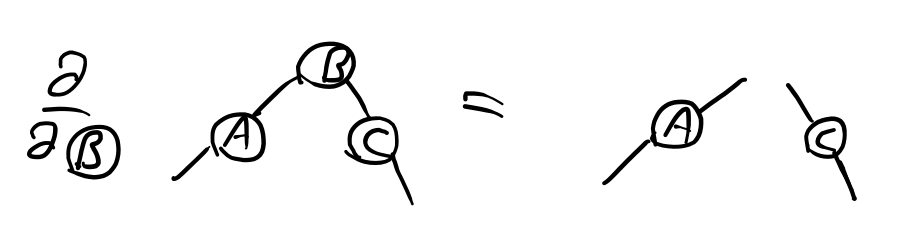

As another example:

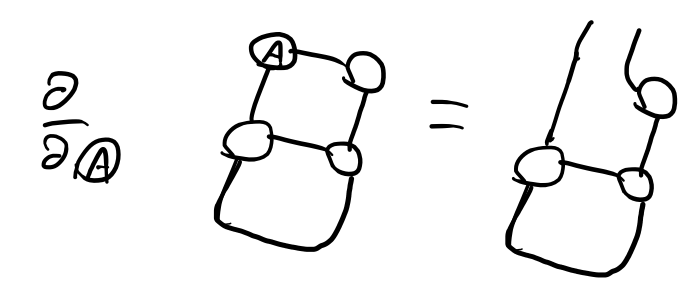

So now we consider our energy, to minimize it and to take into account that the norm of our states is 1, we can use Lagrange multipliers. We want to minimize:

$$\mathcal{L} = {\braket{\Psi |\mathcal{H}|\Psi}} - \lambda({\braket{\Psi|\Psi}}-1) $$

Now, instead of just minimizing it over all of our states, the way we can derive the DMRG algorithm is by thinking in terms of MPS. If we have our states described by a tensor network, we want to avoid optimizing over the whole posible states at once. The idea is then to optimize tensor by tensor! Step by step. This can be written mathematically as follows, which we take from reference [3].

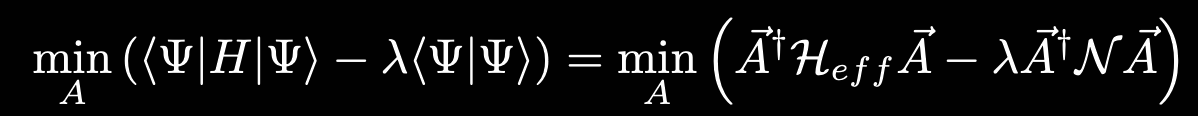

To optimize over complex numbers, we could optimize indepently with respect to the real part or the complex part, but a very useful strategy that can be done with complex numbers is to instead optimize over A and its complex indepently. In our case we optimize over the conjugate:

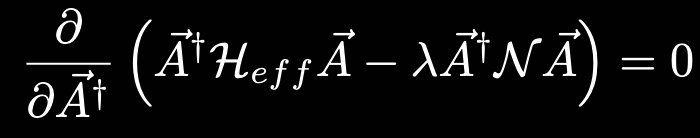

Which leads to the generalized eigenvalue problem:

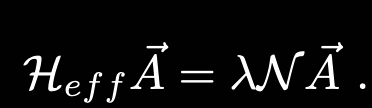


But actually, when usign canonical forms, this will simplify greatly! As $\mathcal{N}$ will just be the identity. To arrive to these derivatives and effective matrix and $\mathcal{N}$ term, it's much easier to see it diagramatically:
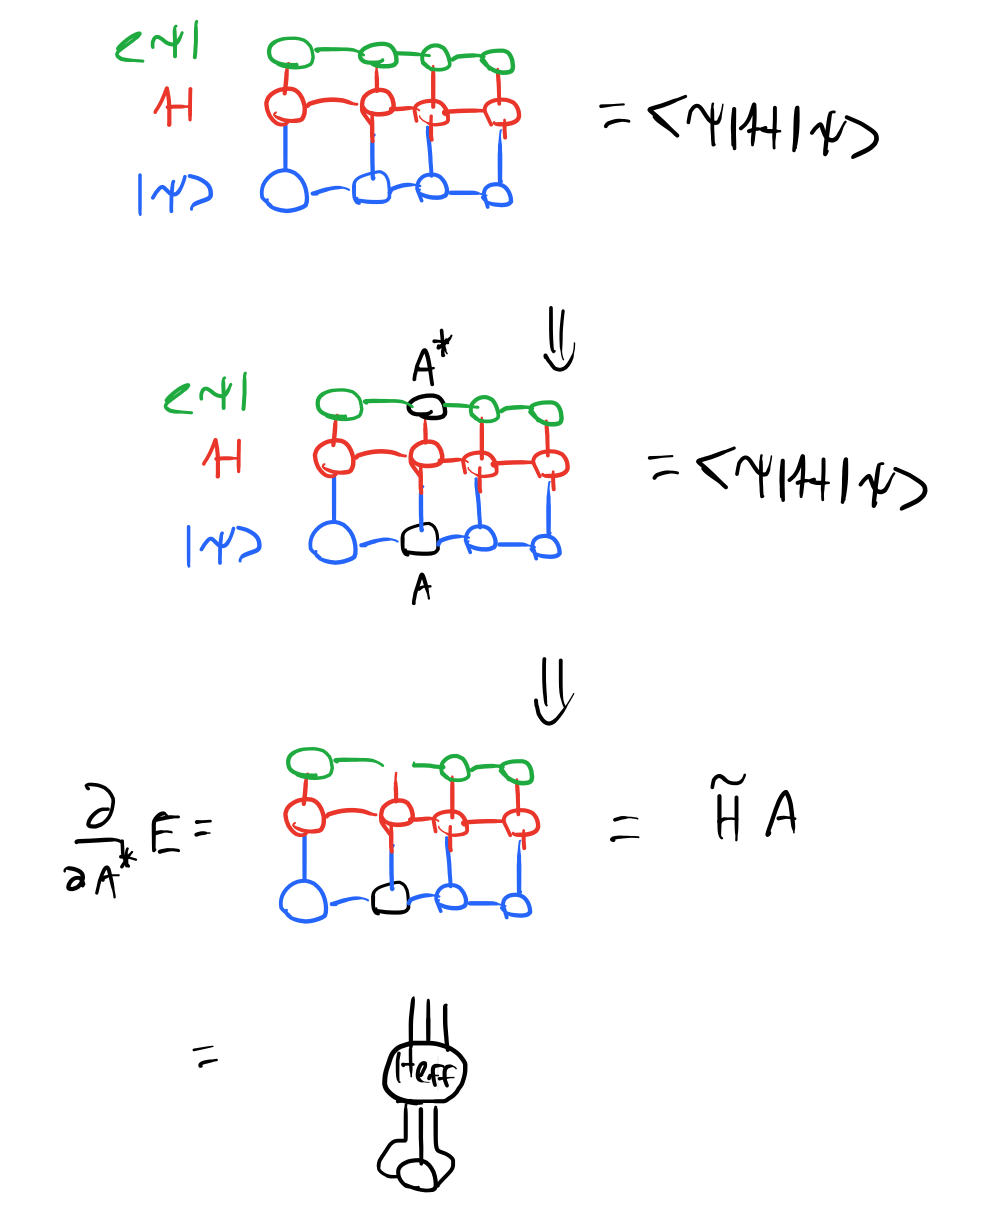

Likewise for the norm term

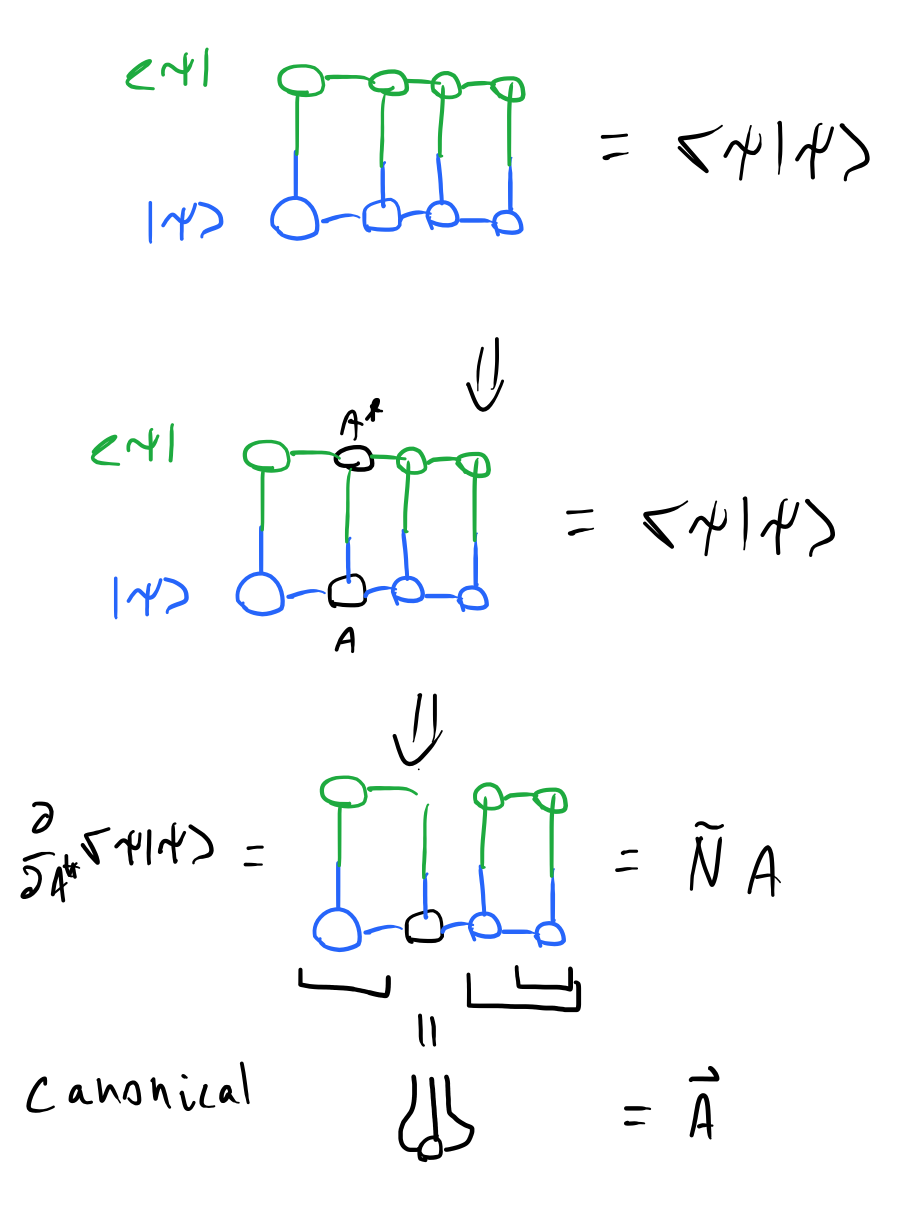

So finally, the problem turns into solving these effective eigenvalue problems for the different tensor sites. In order to do this calculation, during the DMRG algorithm this optimization is sweeped over the different tensors, putting things back into canonical form when necessary and iterating until adequate convergence.


The success of the method relies on the fact that for these kind of local hamiltonians that can be expressed easily as $MPO$ and for simple $MPS$ states like in 1D spin chains, the ground state **can** be expressed as an MPS efficiently, so this is why the DMRG method converges. 


The discussion of this method is much greater. For instance, one could optimize with two tensors at a time, instead of just one, which can help shake things up more and add missing entanglement.

### 4.1. Implementation with library `TeNPy`

Here we implement a tensor network library to solve a problem using the DMRG method:

We will study the phase diagram of a simple spin model, defined on a chain of $L$ spins 1/2, with a Hamiltonian:
$$H(p,\lambda)=-\sum_i[\sigma_i^z\sigma_{i+1}^z+\lambda\sigma_i^x+p(\sigma_i^z\sigma_{i+2}^z+\lambda\sigma_i^x\sigma_{i+1}^x)]$$



We will use TeNPy's NNN (Next nearest neighbours model), which reads:

$$\begin{split}H = \sum_{\langle i,j \rangle, i < j}
        \mathtt{Jx} S^x_i S^x_j + \mathtt{Jy} S^y_i S^y_j + \mathtt{Jz} S^z_i S^z_j \\
    + \sum_{\langle \langle i,j \rangle \rangle, i< j}
        \mathtt{Jxp} S^x_i S^x_j + \mathtt{Jyp} S^y_i S^y_j + \mathtt{Jzp} S^z_i S^z_j \\
    - \sum_i
      \mathtt{hx} S^x_i + \mathtt{hy} S^y_i + \mathtt{hz} S^z_i\end{split}$$

In [118]:
import tenpy
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

# as we are using next nearest neighbour interaction, we can use tenpy's nnn model
# we remember that sigma = J/2, so we need to rescale appropiately our factors by 2 (or 4)


def model_params(p, lamb, L=2):
    return {"Jz": -4,   "Jy":  0,   "Jx": -4*p*lamb,    #indicate
            "Jxp": 0,   "Jyp": 0,   "Jzp":-4*p,
            "hx":2*lamb,"hy":  0,   "hz":  0,
            "L": L,                             # Length of the chain in terms of GroupedSite, i.e. we have 2*L spin sites. Grouped so nnn interaction is nn in terms of spin pairs. Therefore L=3 is enough as then every one interacts with different second neighbours!
            "S": 0.5,                           # -S, -S+1 ... S-1, S   spins
            "bc_MPS": "infinite"}#, #"bc_x": "open"
            #"conserve": 'None'}  

def model(p,lamb,L=2):
    return tenpy.SpinChainNNN(model_params(p,lamb,L))

In [119]:
# we calculate ground states using DMRG

def DMRG_MPS(D, model):
    """
    D: Maximum bond dimension, svd cutoff
    """

    dmrg_params = dict(
        mixer = None,  # to speed things up, and two site DMRG helps mixing already (more than single site DMRG)
        max_sweeps = 10,
        trunc_params = dict(
            chi_max = D,
            svd_min =1e-8 ,
        ),
    )


    pstate = np.array([1,0,0,0])   # we set initial state to 11, to try.
    #print(model.lat.mps_sites())
    psi = tenpy.MPS.from_lat_product_state(model.lat, [[pstate]], bc="infinite") # we set initial mps corresponding to all spins down
    psi.canonical_form()
    engine = tenpy.TwoSiteDMRGEngine(psi, model, dmrg_params)

    return engine.run()



To check the validity of our results we quickly compare as suggested with the $p=0$ case of the transverse field Ising model, where we indeed find the phase transition at $\lambda=1$

In [121]:
D = 16
p = 0
lamb = np.linspace(0,2, 21)
Elist = []
xilist = []
for l in lamb:
    energy, psi = DMRG_MPS(D, model(p,l))
    Elist.append(energy)
    xilist.append(psi.correlation_length())


final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=6.16e-04
norm_err=4.50e-05 still too high after environment_sweeps
final DMRG state not in canonical form up to norm_tol_final=1.00e-10: norm_err=4.50e-05, calling psi.canonical_form()
final DMRG state not in canonical form up to norm_tol_final=1.00e-10: norm_err=1.37e-10, calling psi.canonical_form()


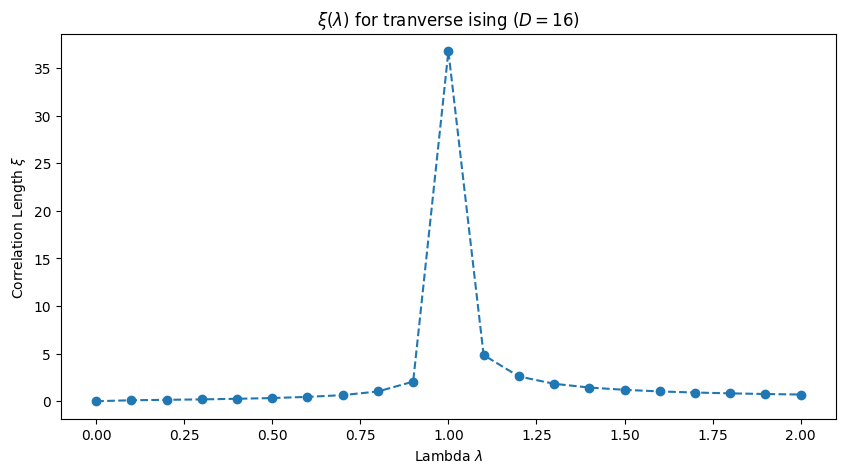

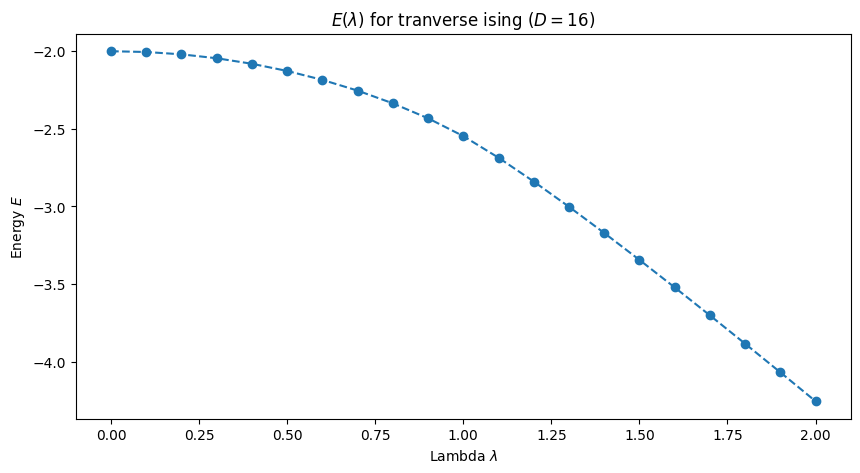

In [122]:
plt.plot(lamb, xilist, "--o")
plt.title(r"$\xi(\lambda)$ for tranverse ising ($D=16$)")
plt.ylabel(r"Correlation Length $\xi$")
plt.xlabel(r"Lambda $\lambda$")
plt.show()

plt.plot(lamb, Elist, "--o")
plt.title(r"$E(\lambda)$ for tranverse ising ($D=16$)")
plt.ylabel(r"Energy $E$")
plt.xlabel(r"Lambda $\lambda$")
plt.show()

## 6. References

[1] Biamonte, Jacob, and Ville Bergholm. “Tensor Networks in a Nutshell.” arXiv, July 31, 2017. https://doi.org/10.48550/arXiv.1708.00006.

[2] Roger Penrose, “Applications of negative dimensional tensors,” in Combinatorial Mathematics and its Applications, edited by D. Welsh (Academic Press, New York, 1971) pp. 221–244.  https://www.mscs.dal.ca/%7Eselinger/papers/graphical-bib/public/Penrose-applications-of-negative-dimensional-tensors.pdf

[3] Orus, Roman. “A Practical Introduction to Tensor Networks: Matrix Product States and Projected Entangled Pair States.” Annals of Physics 349 (October 2014): 117–58. https://doi.org/10.1016/j.aop.2014.06.013.


### Solutions extras


Here you will find the drawings that describe the implemented solution of the contraction exercise:


We want to contract:

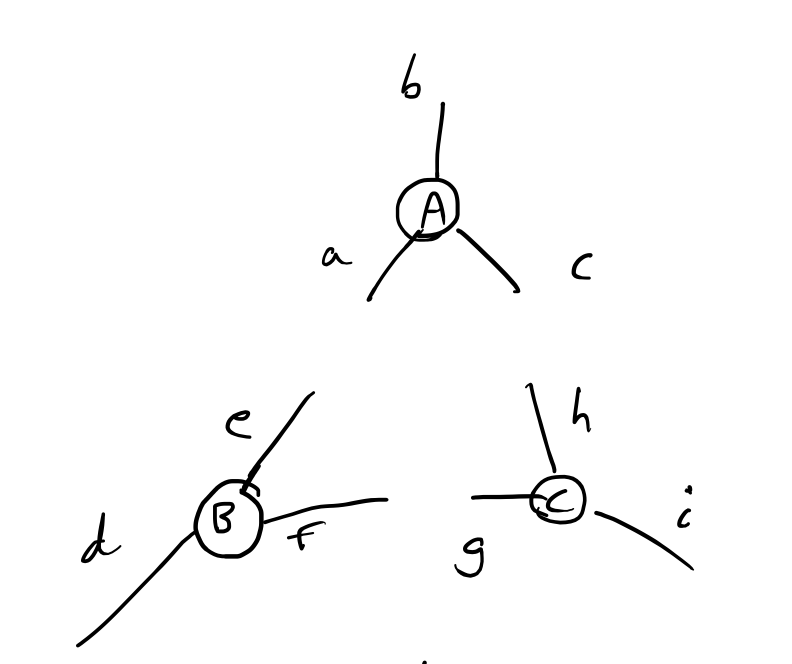



The first method corresponds to:

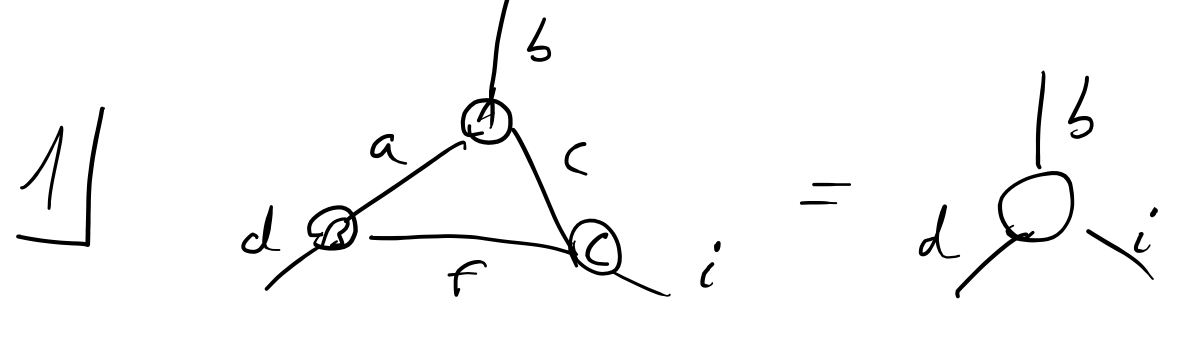


The second one corresponds to:

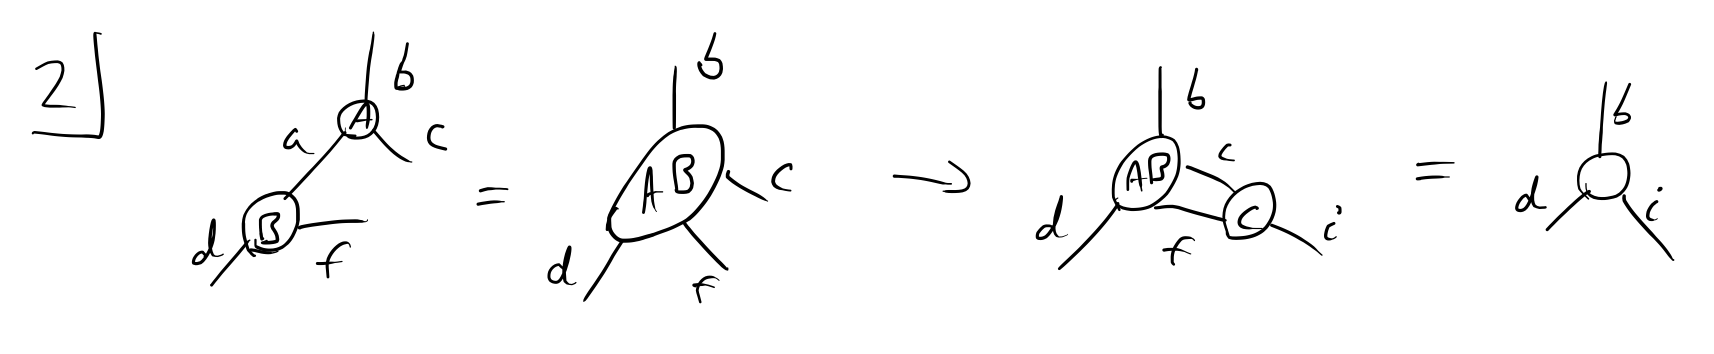



And the other one corresponds to:

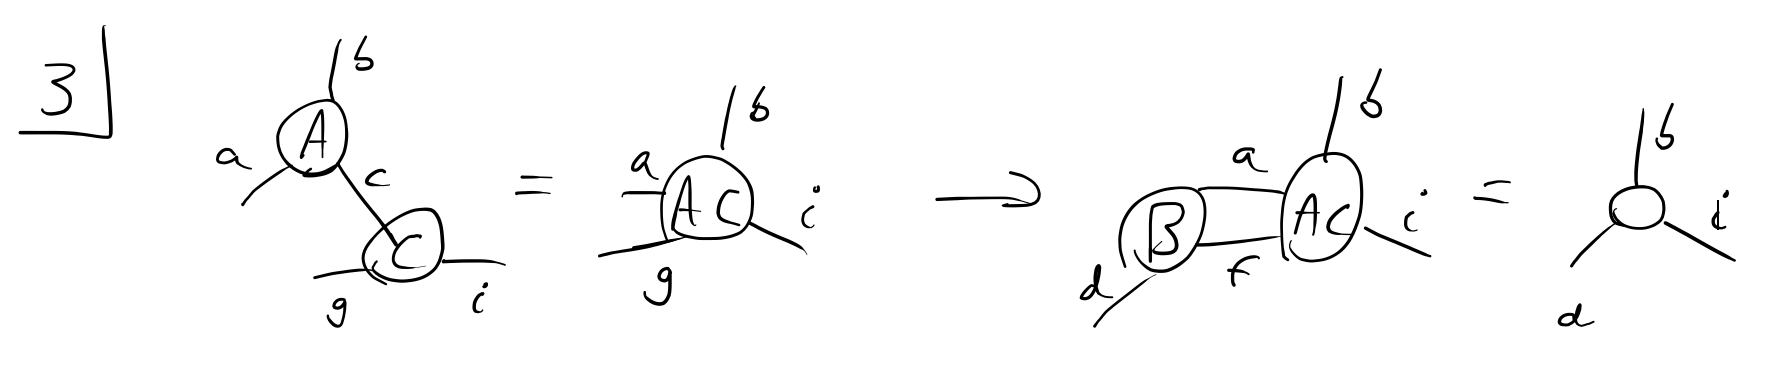

#### MPS Exercise

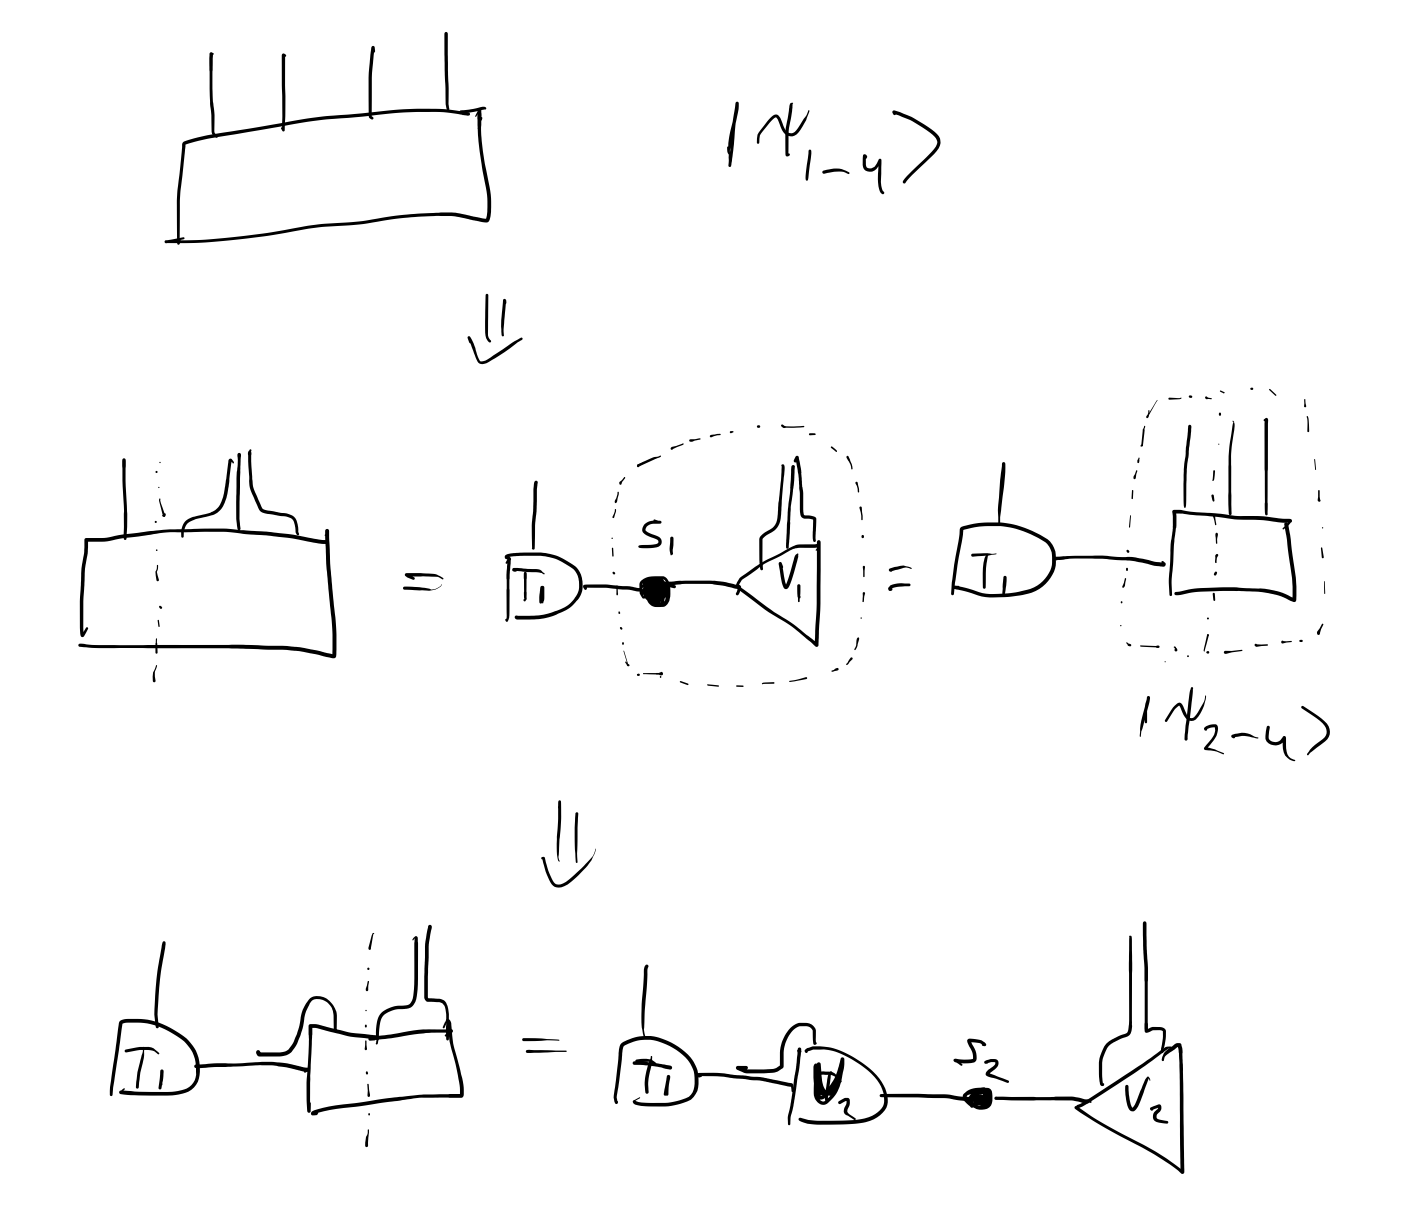

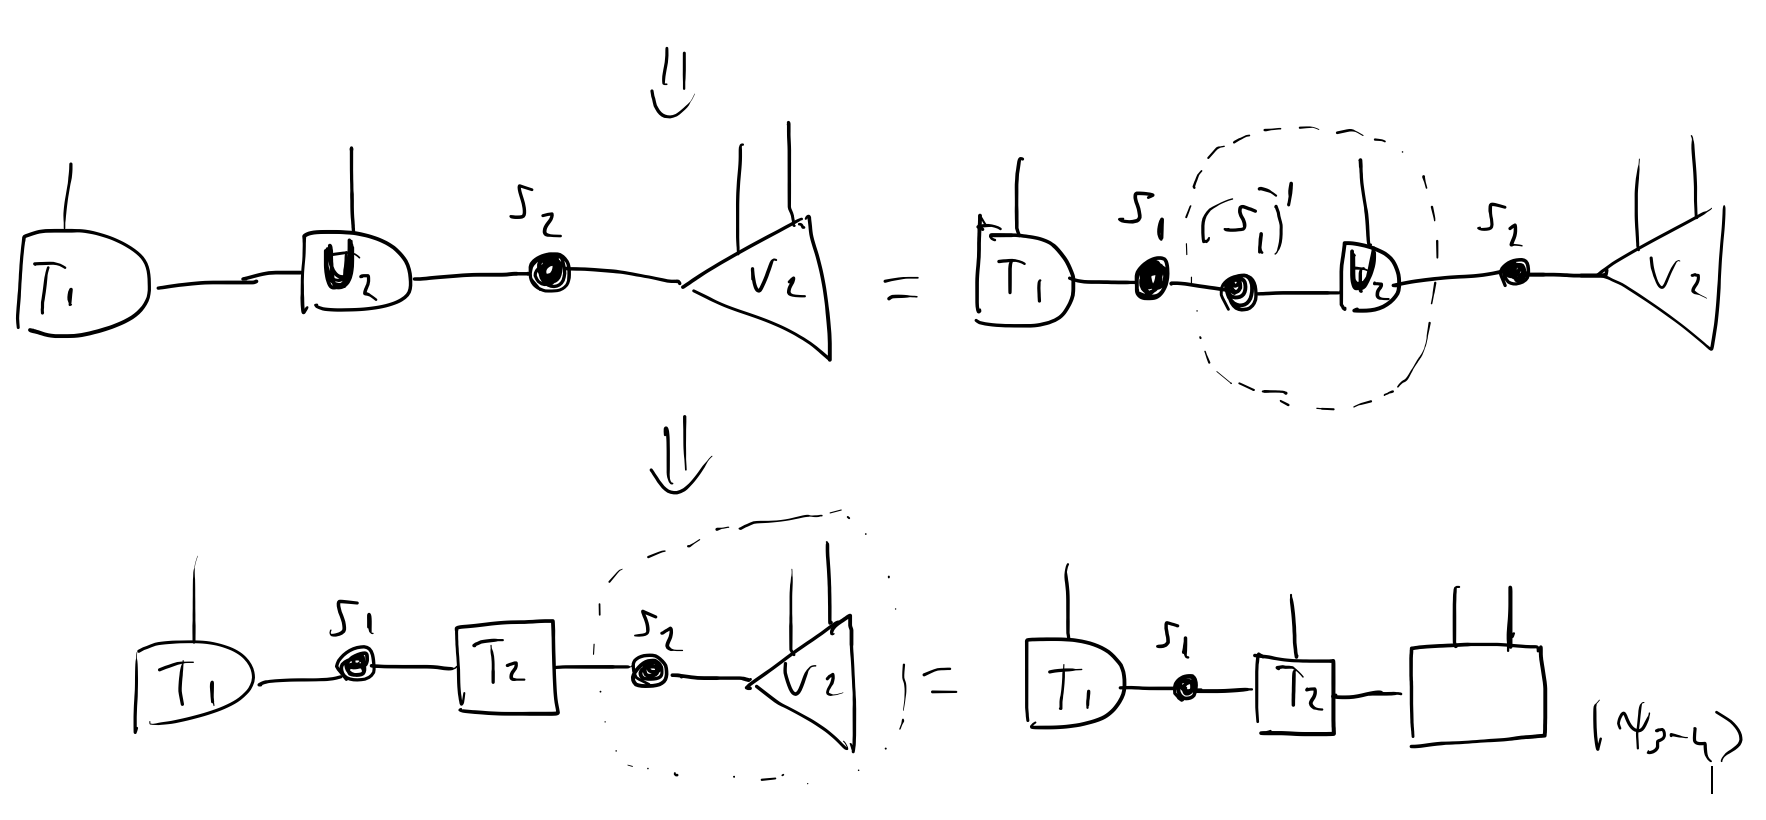

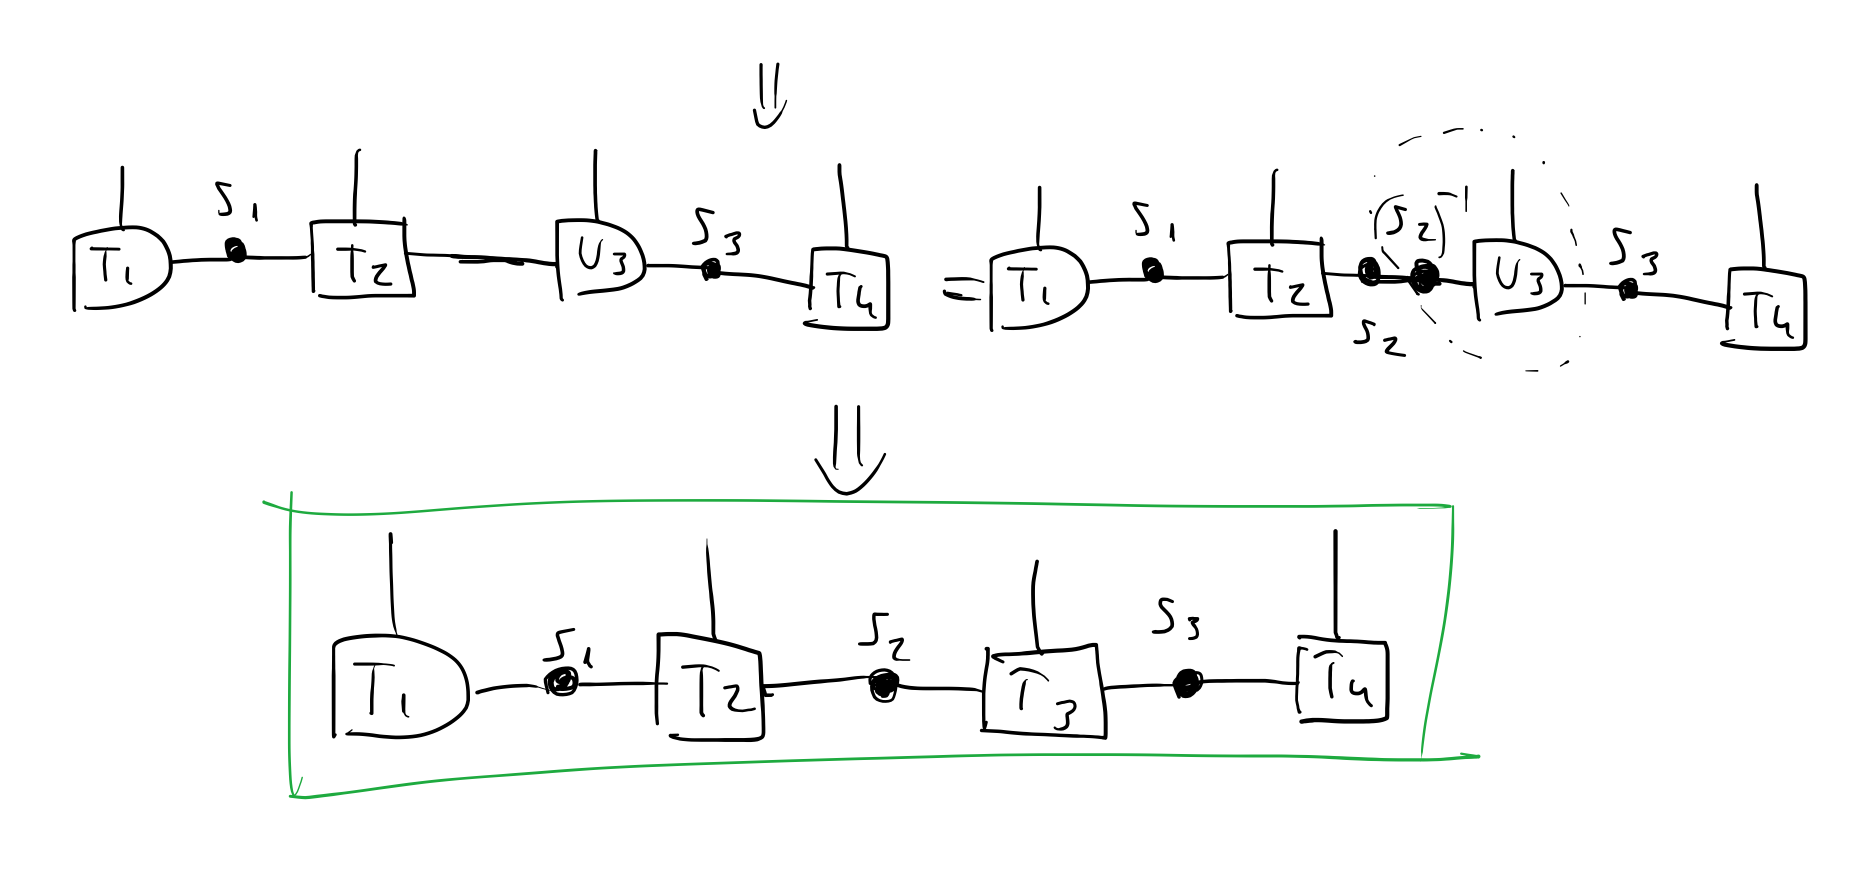